# LINK TO GITHUB: [Ran+Shany Repo](https://github.com/RyanWri/Afeka_DL_course_labs/tree/main/src/task_2)

**All our code is organized, you can find task2 in src/task_2 directory**

In [1]:
import os
import sys
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
# Allow nested use of asyncio.run()
nest_asyncio.apply()

**Next Cell is for Import readibility**

In [3]:
# Prepend the src directory to the PYTHONPATH
sys.path.insert(0, os.path.abspath(os.getcwd()))

# Verify that the path has been added
print(sys.path[0])

c:\Afeka\Afeka_DL_course_labs


# 1 Use the dataset from UCI Machine Learning Repository
**We read the data and split it into 10 different chunks for faster reading, data files located in src/task_2/data directory**
<br>*Asyncio is an asynchornous library for fast processing time*

In [4]:
from src.task_2.eda.eda import load_and_process_chunk

async def process_data_parallel():
    rootdir = os.path.join(os.getcwd(), "src", "task_2", "data")

    # Traverse Data Directory and get paths to all chunk files
    file_names = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            file_names.append(os.path.join(subdir, file))
    
    # Load and process each chunk
    tasks = [load_and_process_chunk(file) for file in file_names]
    results = await asyncio.gather(*tasks)

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(results)
    return full_df

# Run the asynchronous processing
full_df = asyncio.run(process_data_parallel())

# 2. Perform Exploratory Data Analysis (EDA) of the dataset

In [5]:
# Display the first few rows of the dataset
display(full_df.head())

# Summary statistics
display(full_df.describe())

# Display information
display(full_df.info())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.083262e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.021964e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,5.578000e+00,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2008-12-06 07:12:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


None

Creating a new feature by converting the Global active power from KW to W/h

In [6]:
# Convert kilowatt to watt hourly and divide by 60 to represent hourly data
full_df['Global_active_power_wh'] = full_df['Global_active_power'] * 1000 / 60

Creating a new feature to represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [7]:
# Create a new feature: kilowatt per hour minus sub_metering_1, sub_metering_2, sub_metering_3
full_df['active_energy_without_subs'] = full_df['Global_active_power_wh']-( full_df['Sub_metering_1']+full_df['Sub_metering_2']+full_df['Sub_metering_3'])

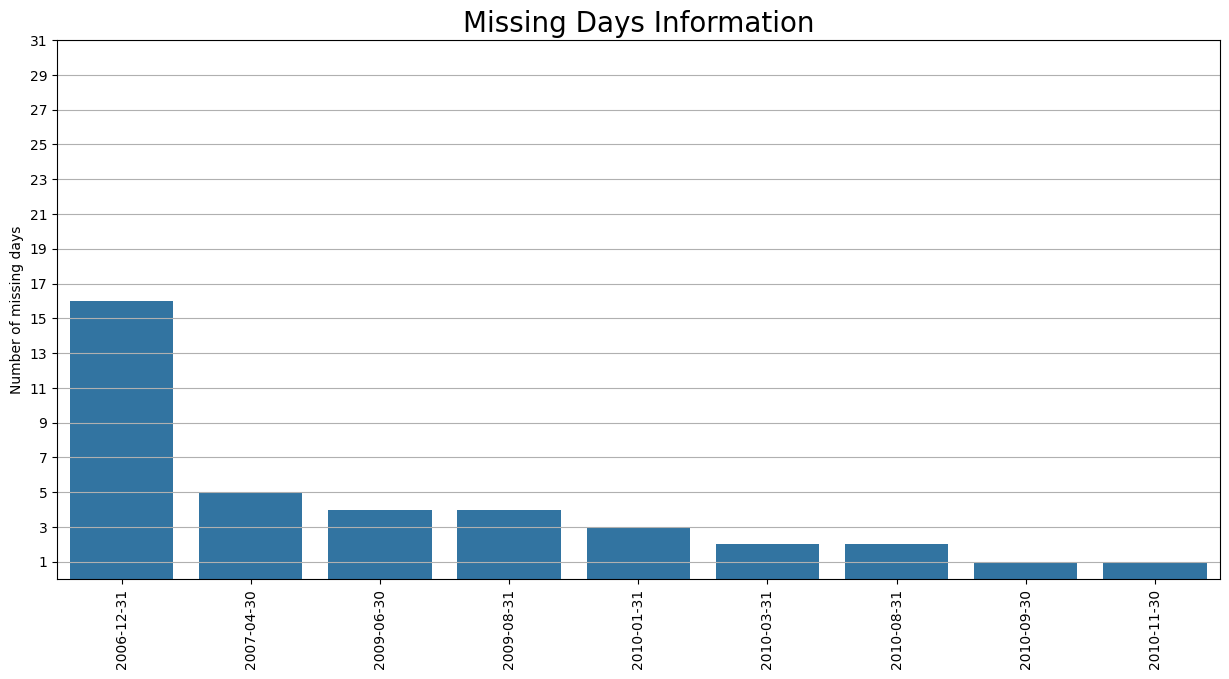

In [9]:
# Let's find out how many days have not been recoreded in our dataset
missing_days_df = np.round(full_df[['Global_active_power_wh']].resample('ME').count()/1440).astype(int)
missing_days_df.columns = ['Number of missing days']
missing_days_df['Number of missing days'] = missing_days_df.index.astype(str).str[-2:].astype(int) - missing_days_df['Number of missing days']
# Drop the rows where the number of missing days is 0
missing_days_df.drop(missing_days_df[missing_days_df['Number of missing days']==0].index,inplace=True)

# Drawing the plot
plt.figure(figsize=(15,7))
sns.barplot(
    data = missing_days_df,
    x = missing_days_df.index.date,
    y = missing_days_df.sort_values(by=['Number of missing days'],ascending=False)['Number of missing days']
)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1,32,2))
plt.xlabel('')
plt.grid(axis='y')
plt.title('Missing Days Information',fontsize=20)
plt.show()

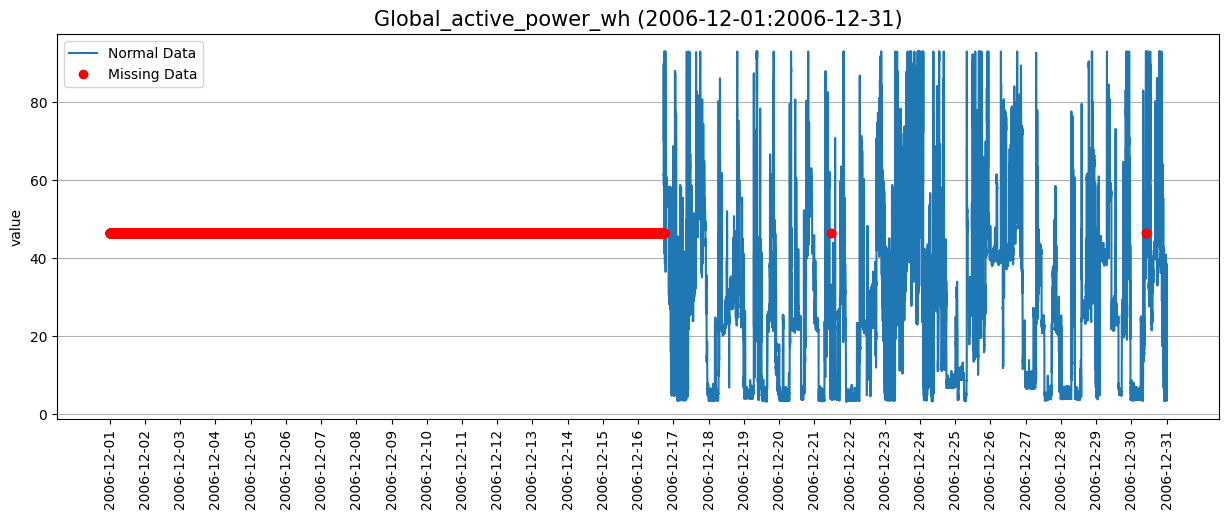

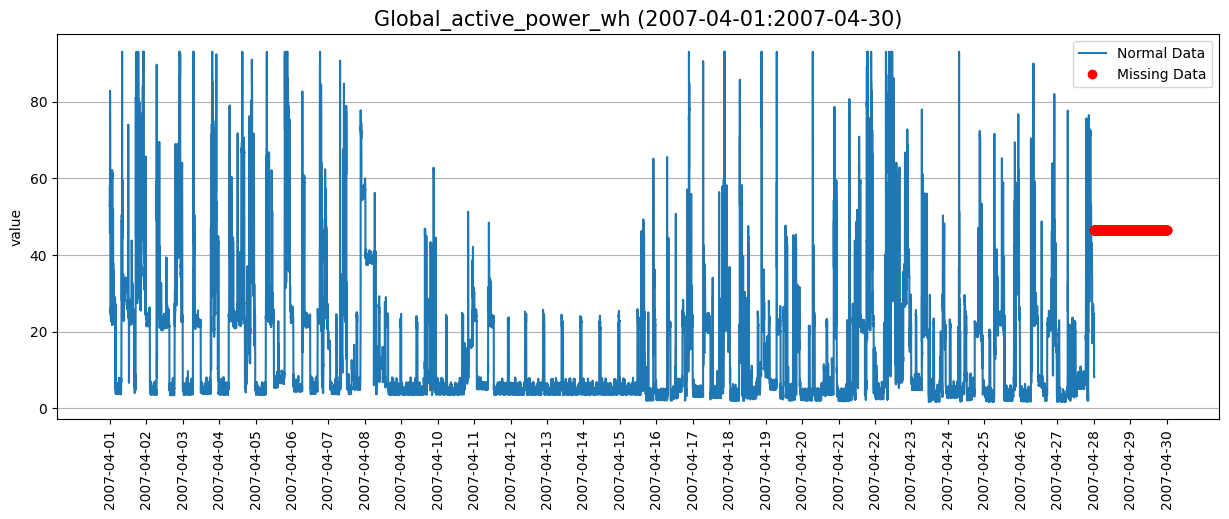

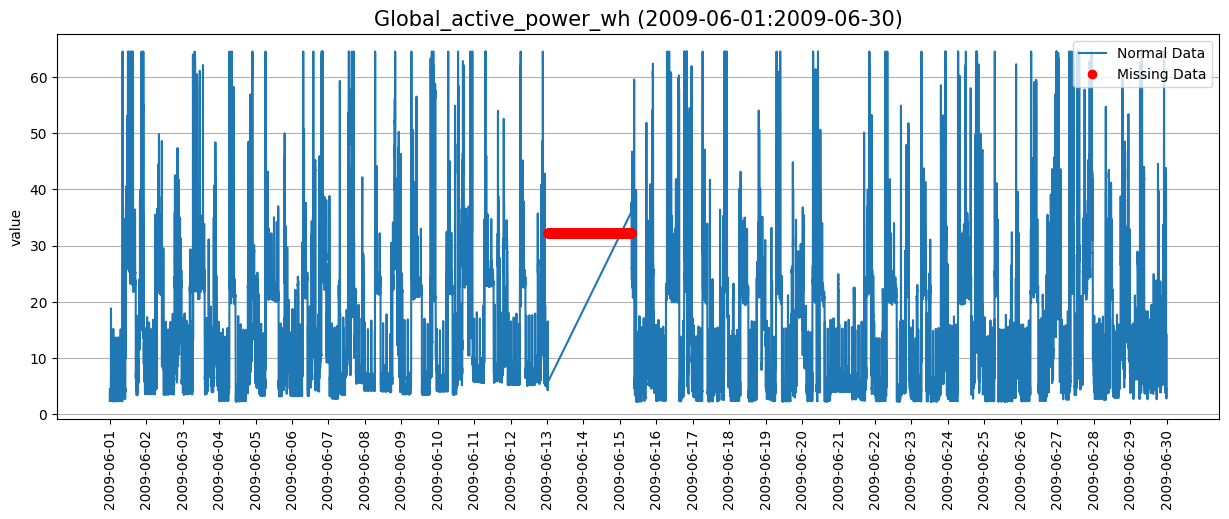

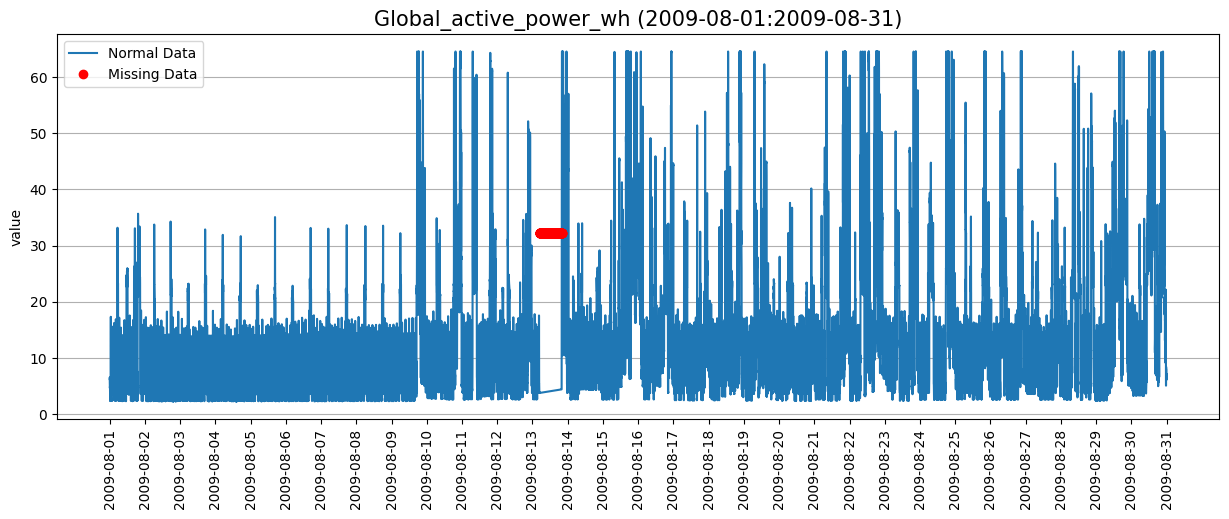

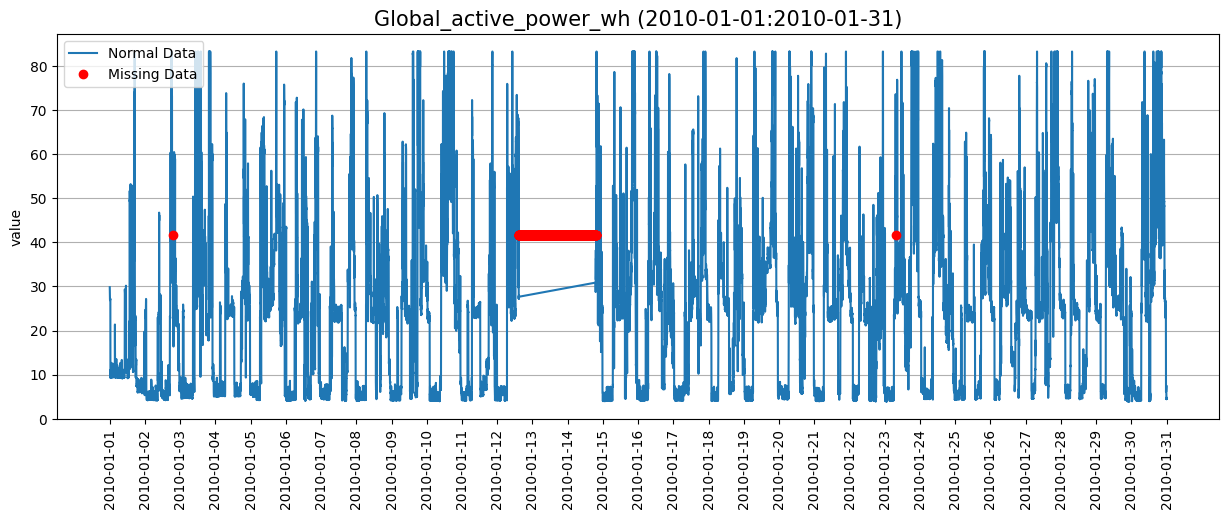

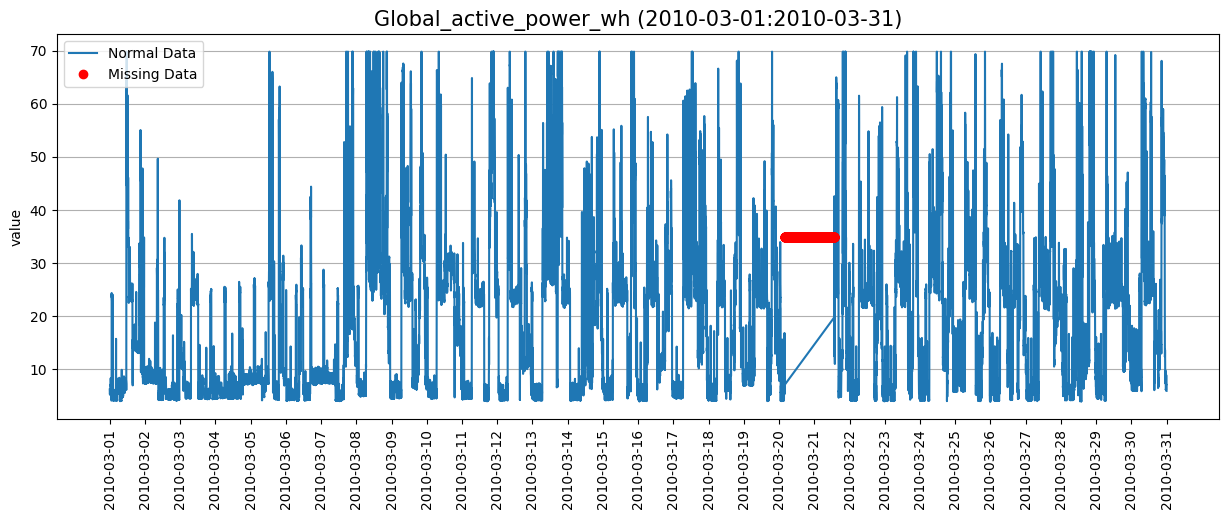

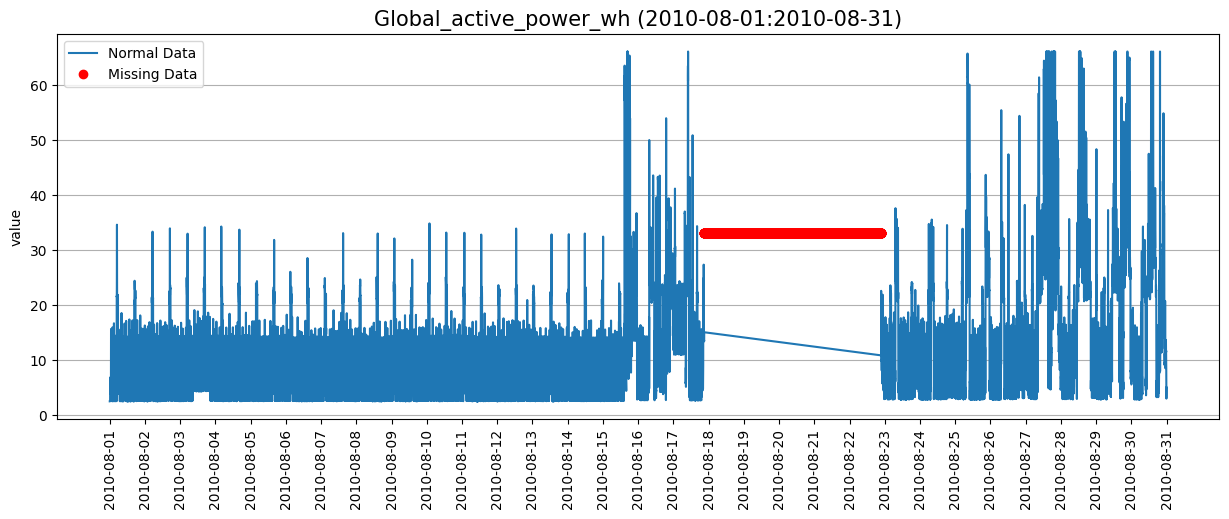

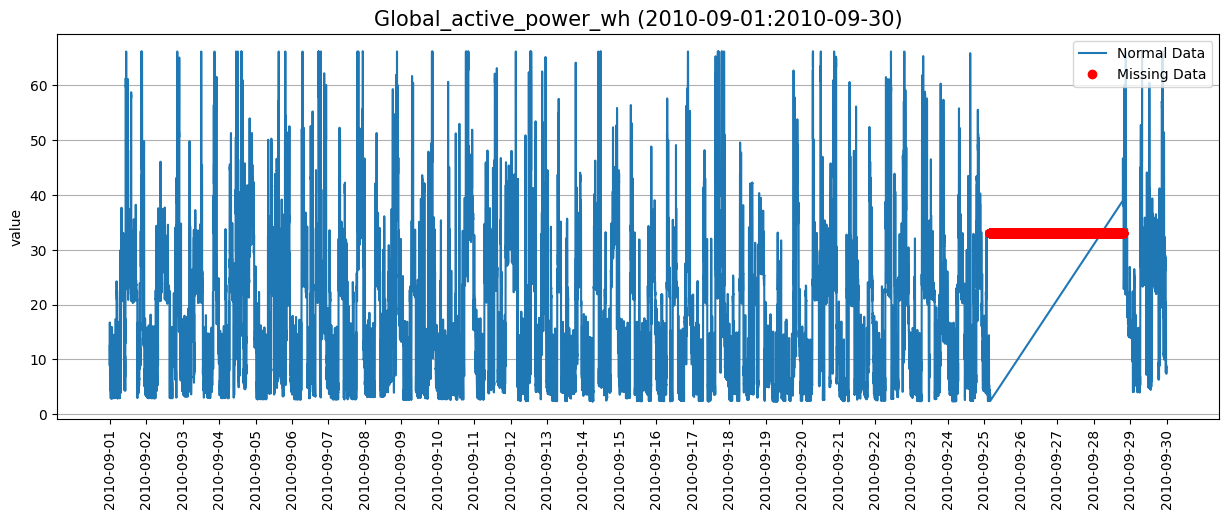

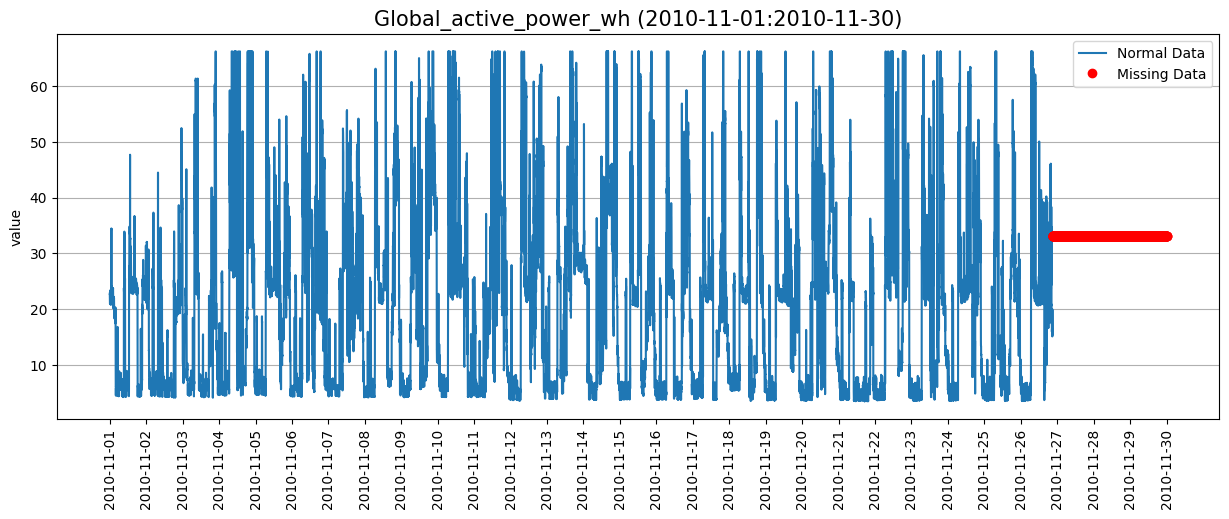

In [10]:
import datetime
def plot_day_data(day:datetime.date) -> None:
    '''
    The function "plot_day_data" plots the "Global_active_energy" values 
    for a given date as input. The input date is used to filter the data
    and fill in any missing values with NaN. On the plot, the missing
    values are marked with markers. The X-axis displays xticks for the
    specified day and the Y-axis is labeled as "value". The final plot 
    is displayed using the matplotlib library.
    
    Parameters:
        day : datetime.date
        
    Return:
        None
    '''
    # Create time range and xtick for the day
    time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1min')
    xtick_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='D')
    
    # Filter the data for the day and fill missing values with NaN
    tmp_df = full_df[['Global_active_power_wh']][full_df.index.isin(time_range)].copy()
    tmp_df = tmp_df.combine_first(pd.DataFrame(index=time_range, columns=tmp_df.columns))
    
    # Calculate the marker place
    marker_place = tmp_df[['Global_active_power_wh']].max().item() / 2
    # Identify the missing values
    missing_values = tmp_df.isna().any(axis=1)
    
    # Drawing the plot
    plt.figure(figsize=(15, 5))
    plt.plot(
        tmp_df[['Global_active_power_wh']][~missing_values],
        label = 'Normal Data'
    )
    plt.plot(
        tmp_df[['Global_active_power_wh']][missing_values].fillna(marker_place), 
        marker='o', 
        linestyle='None',
        label = 'Missing Data',
        color = 'r'
    )
    plt.xticks(xtick_range, rotation=90)
    plt.grid(axis='y')
    plt.title('Global_active_power_wh ({}:{})'.format(str(time_range[1].date()),str(time_range[-1].date())),fontsize=15)
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return None
for day in missing_days_df.index.date:
    plot_day_data(day)

**Conclusions** <br>
As was reported in the dataset information, we can see that the data contains missing data as gaps. <br>
The data collection for the first month didn't start from the beginning of the month, but on the 17th (Dec 2006).<br>
The data collection for the last month ended before the end of the month, on the 27th (Nov. 2010). <br>
There are 7 more gaps, as seen in the plots above.

## 2.1 Visualize Time Series Trends


In [13]:
def resample_data(full_df, res = '2min'):
    # Assuming 'full_df' has a datetime index 'dt'
    full_df["Datetime"] = full_df.index  # Ensure the datetime index is a column

    # Resample to 2-minute intervals by taking the mean
    resampled_df = full_df.resample(res, on="Datetime").mean()

    # Drop rows with NaN values after resampling
    resampled_df = resampled_df.dropna()

    # Print the first few rows to check the result
    print(resampled_df.head())

    return resampled_df

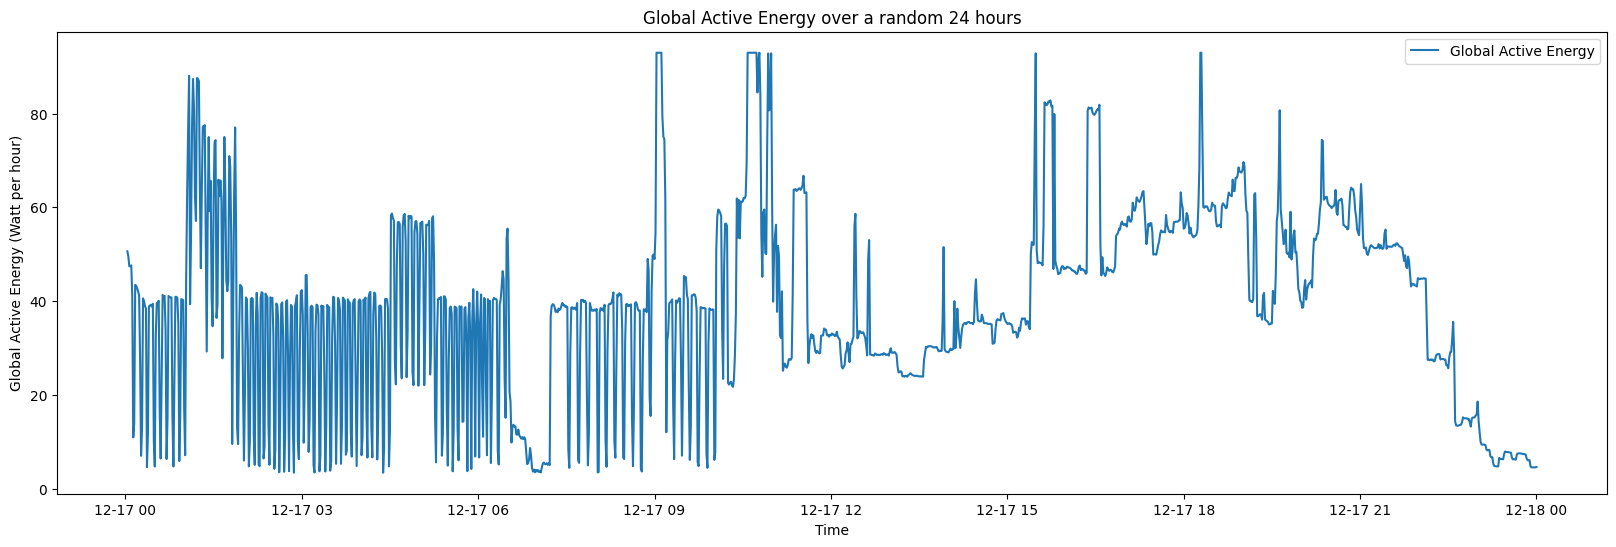

            Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                             
2006-12-16             3.034131               0.088187  236.243763   
2006-12-17             2.348336               0.156949  240.087028   
2006-12-18             1.530032               0.112356  241.231694   
2006-12-19             1.144865               0.104821  241.999313   
2006-12-20             1.543706               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2006-12-16         13.082828        0.000000        1.378788       12.439394   
2006-12-17          9.999028        1.411806        2.907639        9.264583   
2006-12-18          6.421667        0.738194        1.820139        9.734722   
2006-12-19          4.926389        0.582639        5.279167        4.303472   
2006-12-20          6.467361 

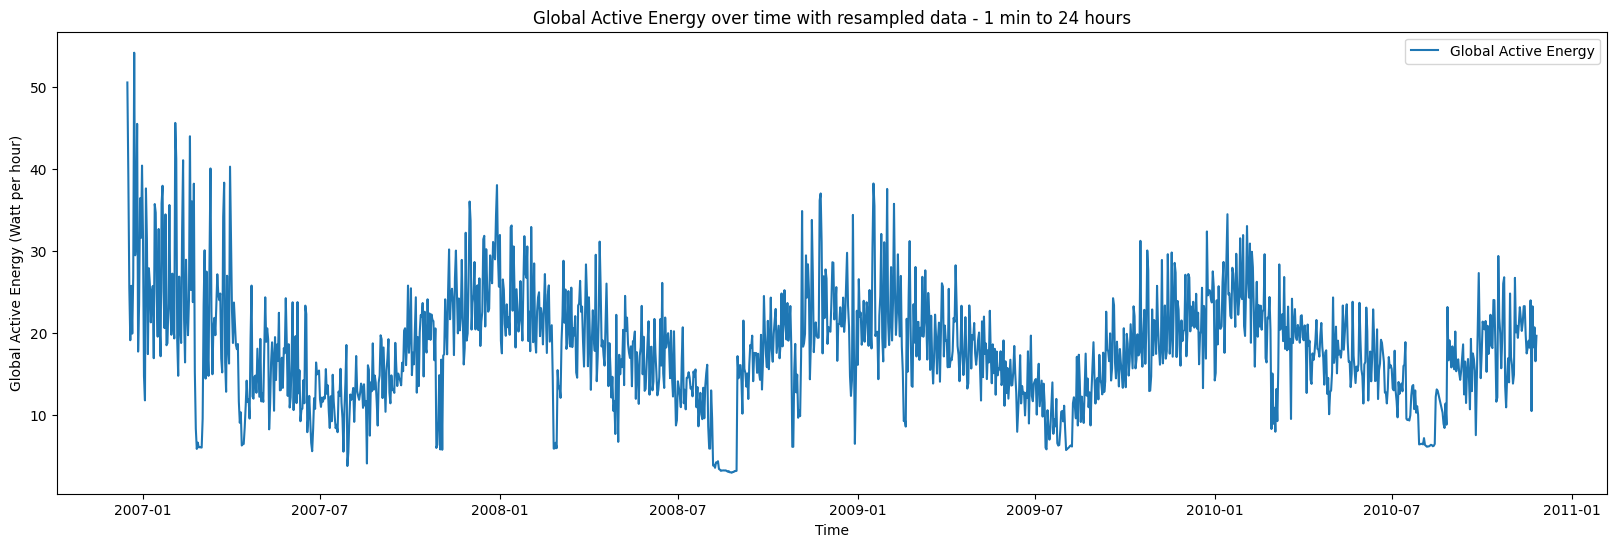

            Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                             
2006-12-31             1.886638               0.131386  241.441125   
2007-01-31             1.534599               0.132676  240.905101   
2007-02-28             1.392162               0.113637  240.519390   
2007-03-31             1.311469               0.114747  240.513469   
2007-04-30             0.888015               0.118778  239.400026   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2006-12-31          8.029956        1.248636        2.214987        7.409558   
2007-01-31          6.546915        1.264237        1.775931        7.383351   
2007-02-28          5.914569        1.180217        1.602361        6.703557   
2007-03-31          5.572979        1.361343        2.346872        6.504648   
2007-04-30          3.825676 

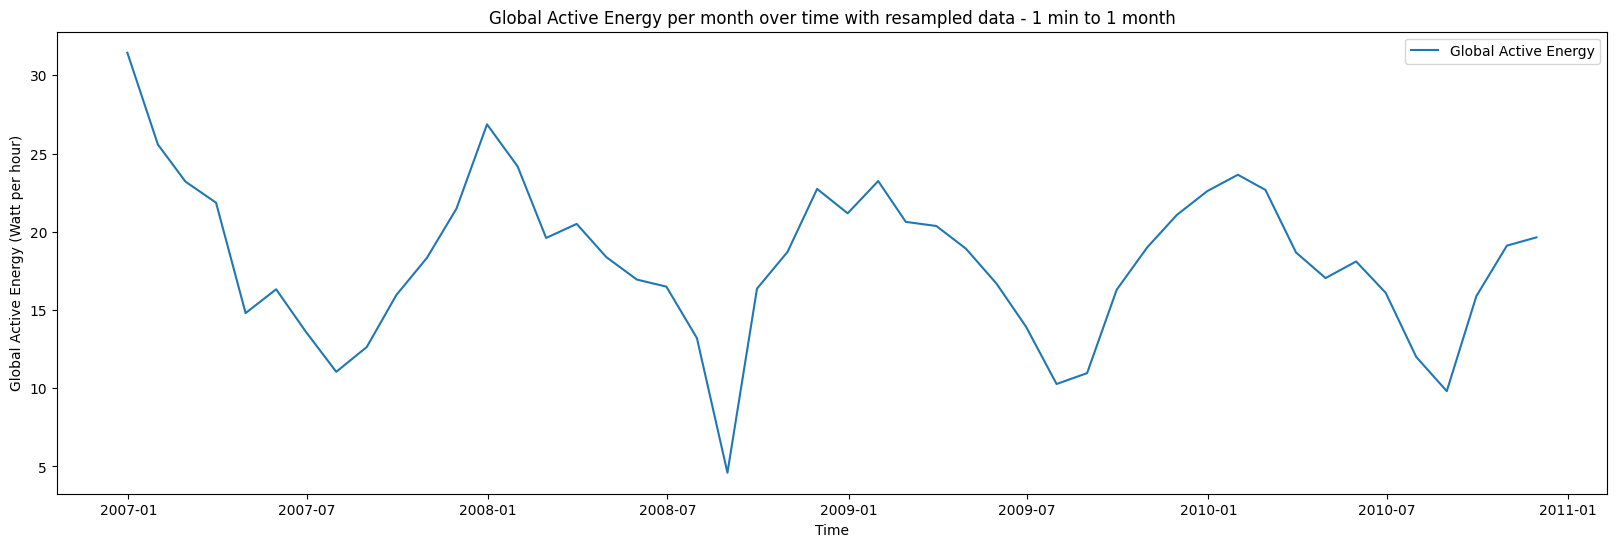

In [14]:
def visualize_time_series_trends(df: pd.DataFrame, title = "Global Active Energy over Time"):
    # Plot Global_active_power over time
    plt.figure(figsize=(20, 6))
    plt.plot(df["Global_active_power_wh"], label="Global Active Energy")
    plt.xlabel("Time")
    plt.ylabel("Global Active Energy (Watt per hour)")
    plt.title(title)
    plt.legend()
    plt.show()


#visualize_time_series_trends(full_df) # Visualizing only all the df without changes
visualize_time_series_trends(full_df.iloc[398:1837], "Global Active Energy over a random 24 hours" ) # Visualizing only 24 hours from original df

resampled_1min_to_24h_df = resample_data(full_df,'1440min') # Resampling the data for better visualization
visualize_time_series_trends(resampled_1min_to_24h_df, "Global Active Energy over time with resampled data - 1 min to 24 hours" )
resampled_1min_to_24h_df = resample_data(full_df,'1ME') # Resampling the data for better visualization
visualize_time_series_trends(resampled_1min_to_24h_df, "Global Active Energy per month over time with resampled data - 1 min to 1 month" )

**Conclusions:** <br>
As the original sample rate of the data is 1/min, it's not possible to plot the full ~4 years of data in one graph.<br>
We plotted 24 hours of the data with the original sample rate to give an example to the intraday variations.<br>
We resampled the data from 1 min to 24 hours and plotted the full duration. We can see that the plot is still very noisy, but we can see the trend and seasonality.<br>
We resampled the data from 1 min to 1 month and plotted the full duration to see the more robust trend and seasonality in the monthly billing.<br>
We will disuse the seasonality further later.

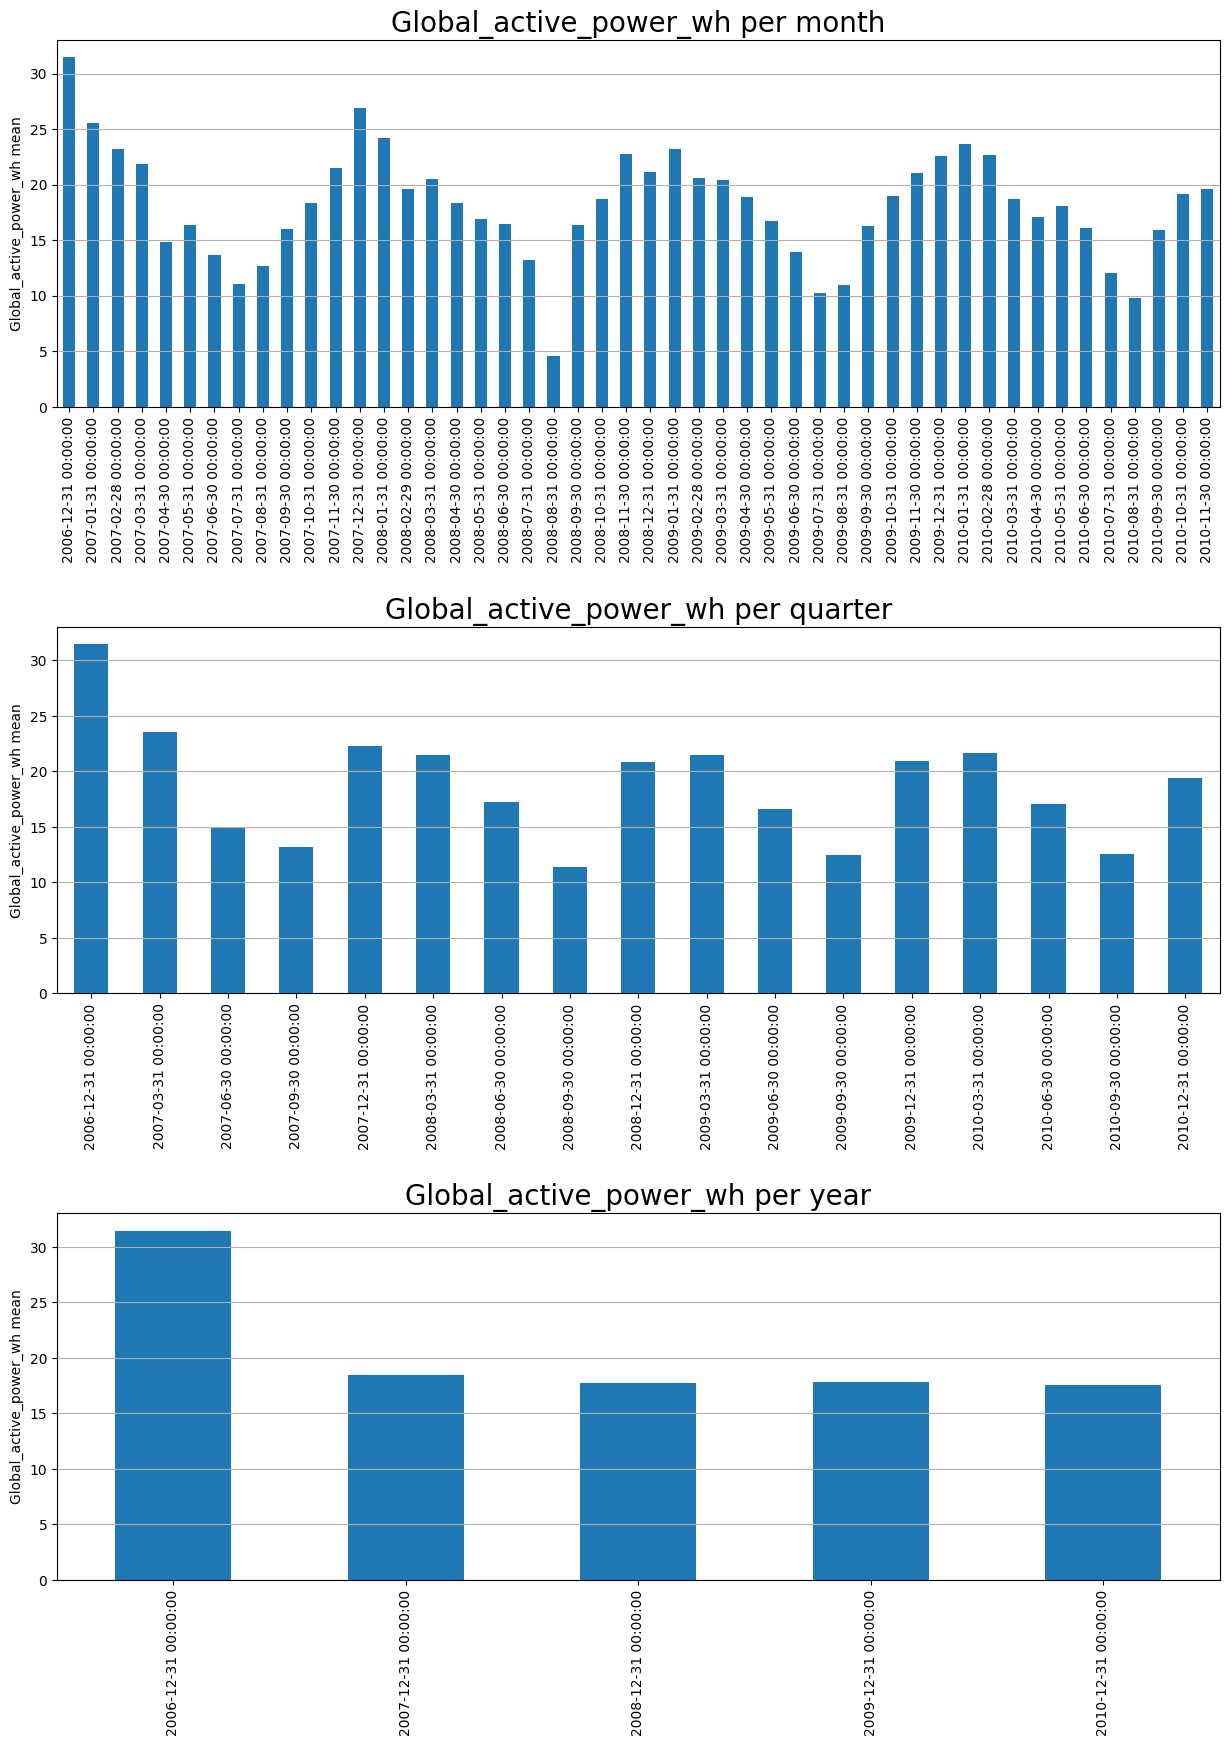

-----------------------------


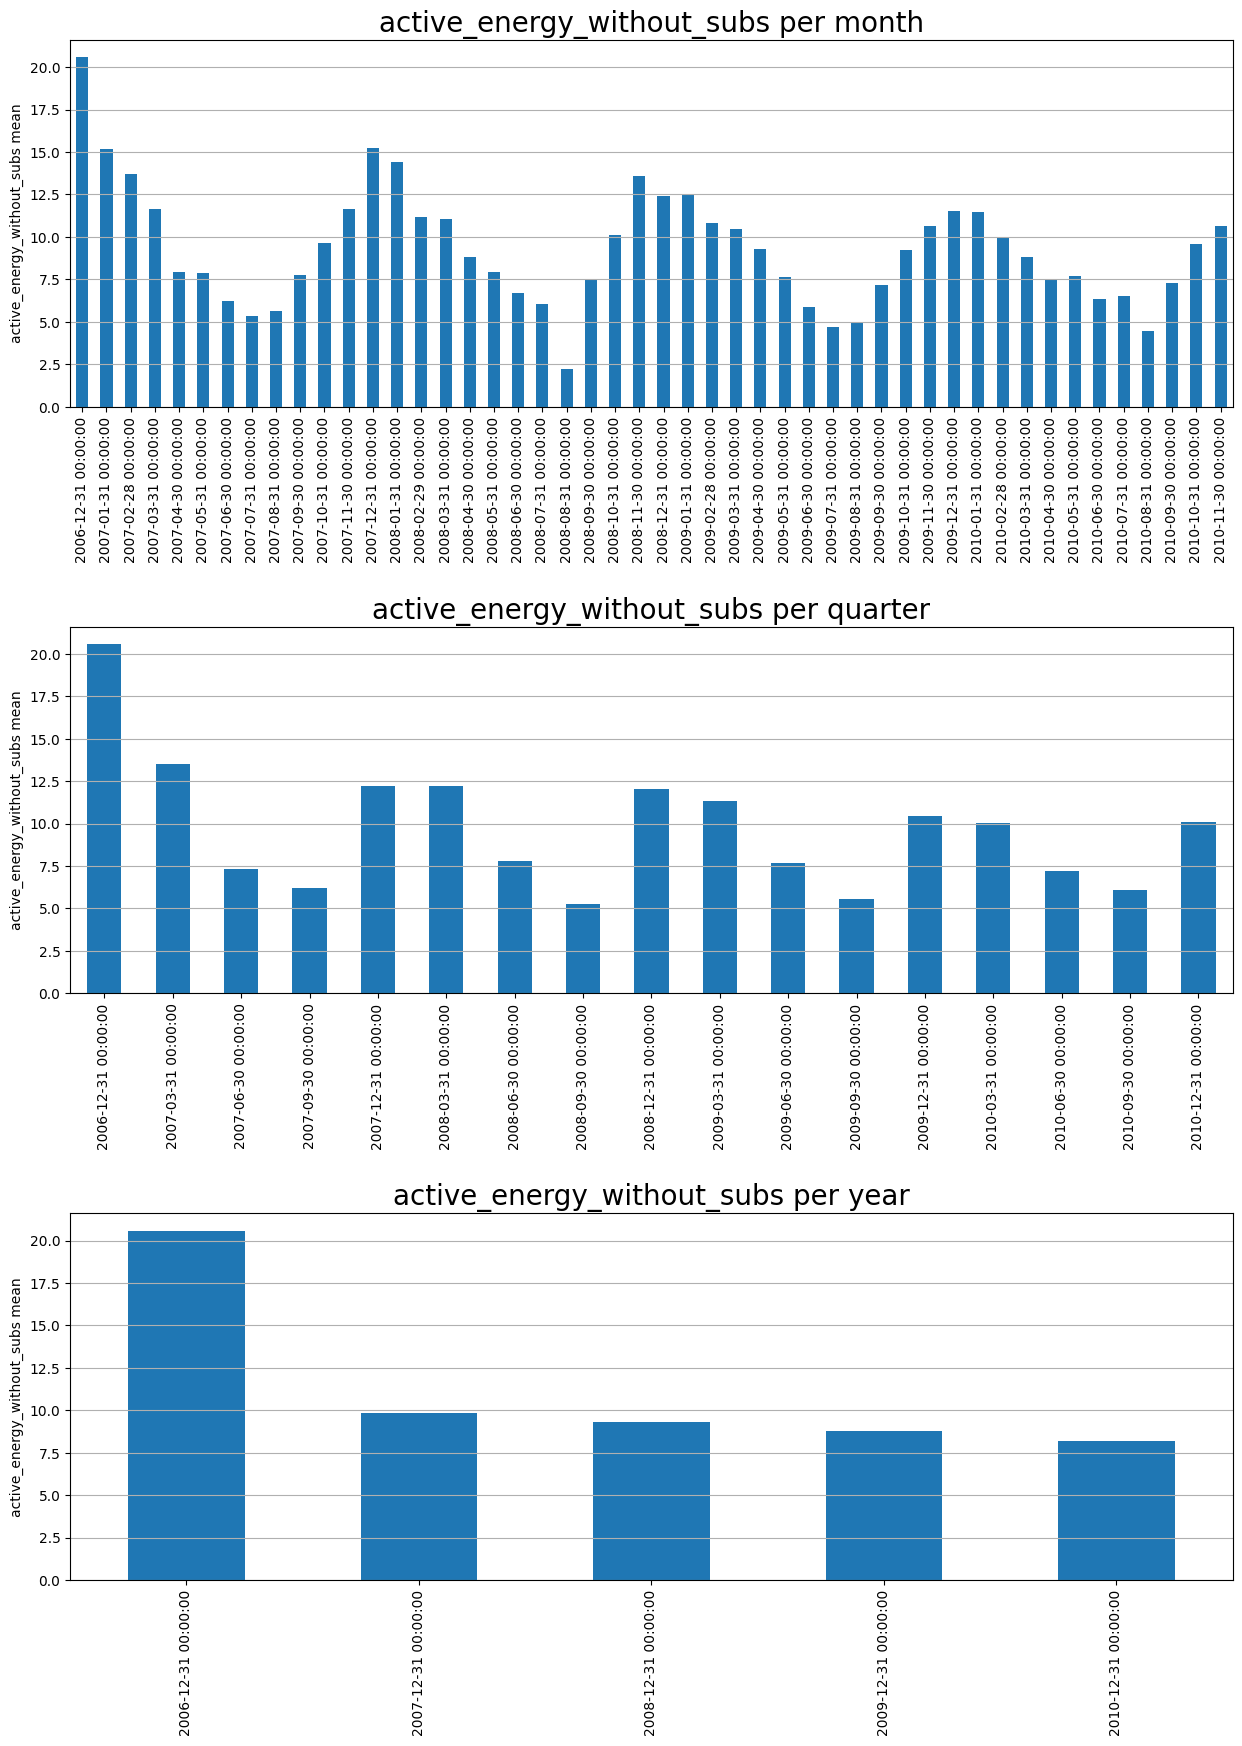

-----------------------------


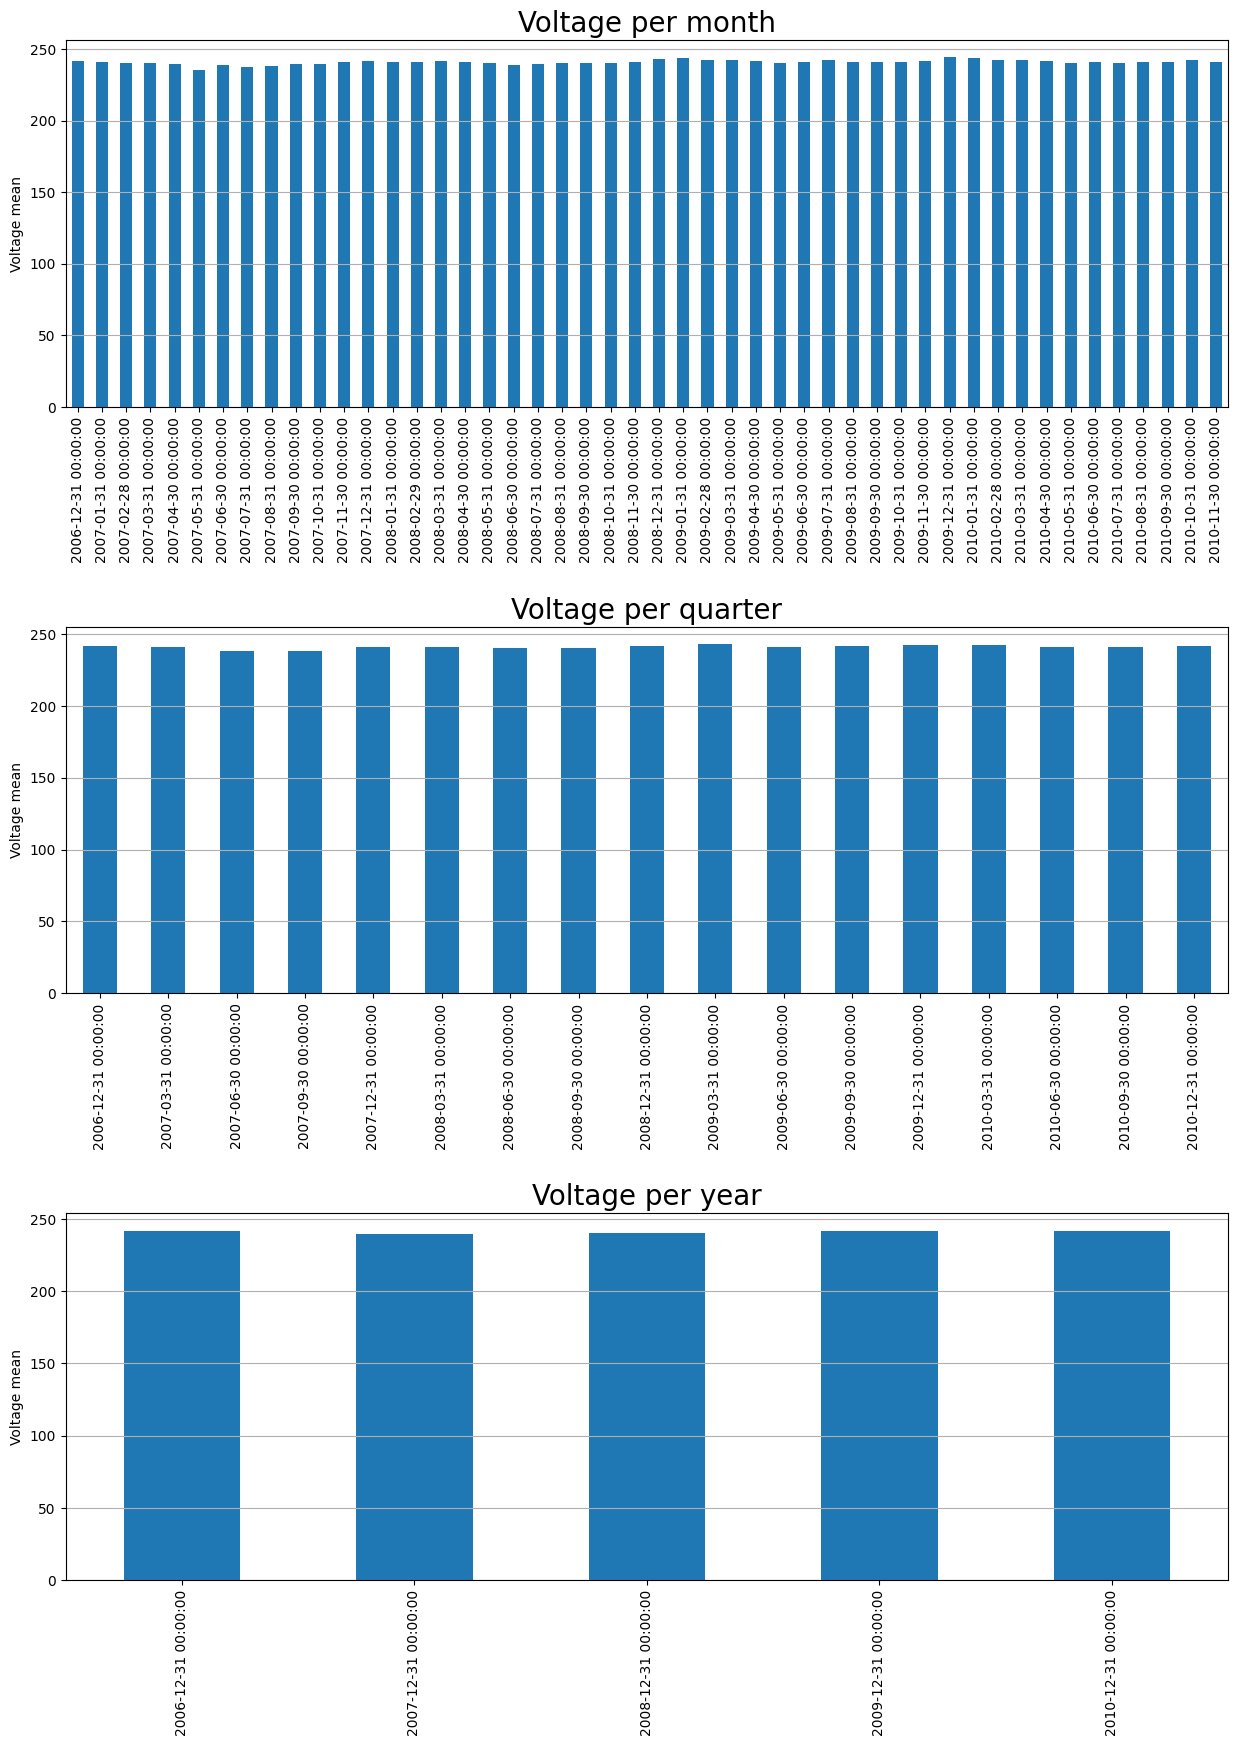

-----------------------------


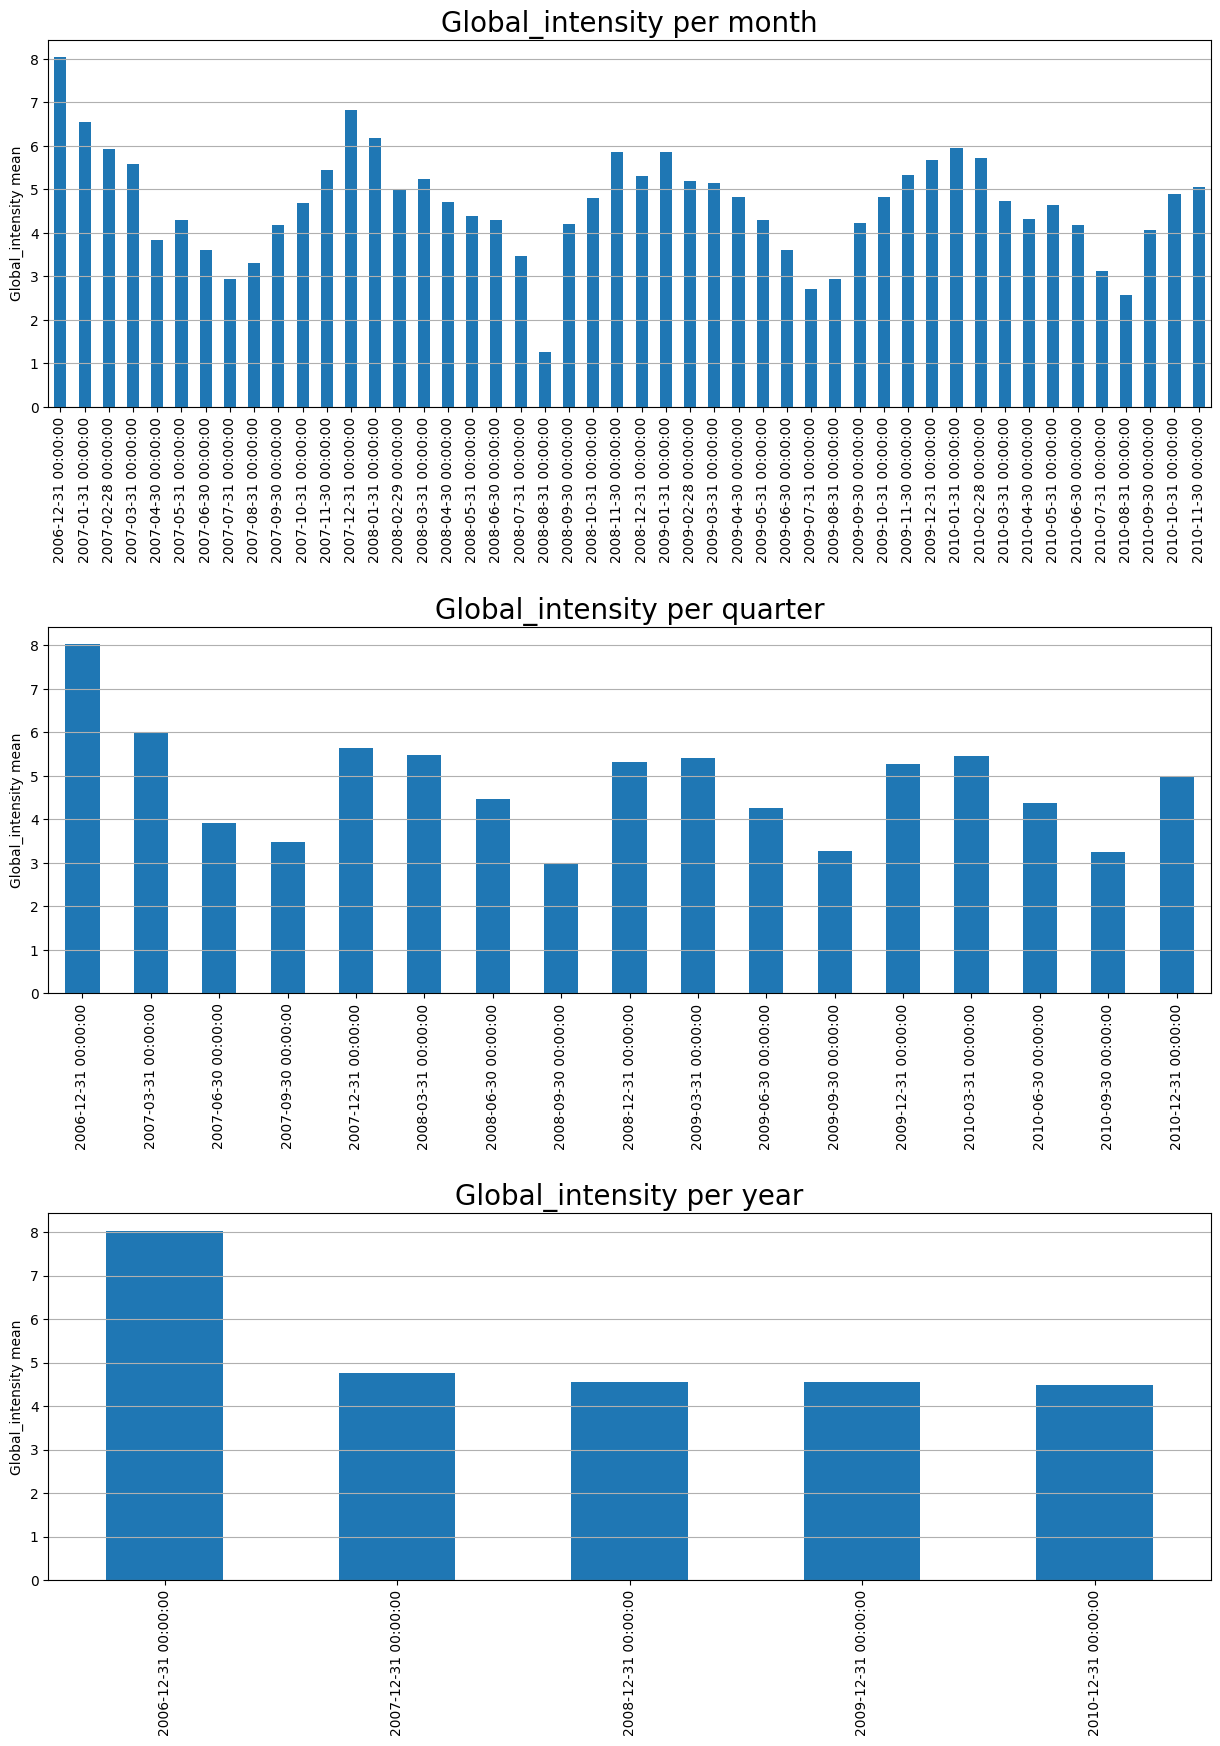

-----------------------------


In [15]:
def feature_analyser(feature:str,df:pd.DataFrame) -> None:
    '''
    This function is to plot mean value of 
    given feature resampled over 'M','Q' and 'Y'

    Parameters:
        feature : string : Column name in the dataframe to be analyzed.
        df : Pandas dataframe : Dataframe to be used for analysis.

    Returns:
        None
    '''
    # Create subplots with 3 rows and 1 column, and set figure size
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
    plt.subplots_adjust(hspace=0.6)  
    
    # Loop through resample intervals: monthly, quarterly, and yearly
    for number, resample in enumerate(['ME', 'QE', 'YE']):
        
        df[feature].resample(resample).mean().plot(kind='bar', ax=ax[number])
        ax[number].set_ylabel('{} mean'.format(feature))
        
        # Set title for each subplot
        if resample == 'ME':
            ax[number].set_title('{} per month'.format(feature), fontsize=20)
        if resample == 'QE':
            ax[number].set_title('{} per quarter'.format(feature), fontsize=20)
        if resample == 'YE':
            ax[number].set_title('{} per year'.format(feature), fontsize=20)
            
        ax[number].set_xlabel('')
        ax[number].grid(axis='y')
        plt.xticks(rotation=90)
        
    plt.show()
    
    print('-----------------------------')
    
    return None

for i in full_df[['Global_active_power_wh','active_energy_without_subs','Voltage','Global_intensity']]:
    feature_analyser(i,full_df)

**Conclusions** <br>
We didn't plot the global reactive power and sub metering features, as we don't think they are relevant to the prediction or for this analysis.<br>

From the plots we can see that:<br>

As expected (from a scientific aspect), the Voltage is constant. We will not use it.<br>
As expected (from a scientific aspect), the intensity has the same pattern as the global power \ energy (power = voltage x Intensity). We will not use it.<br>
The global power Global active energy and the active energy without subs are very similar as the 2nd is a function of the 1st.<br> We created the active energy without subs feature so we wont need to use the 3 sub metering to train the models. We will run a correlation matrix to verify the correlations.

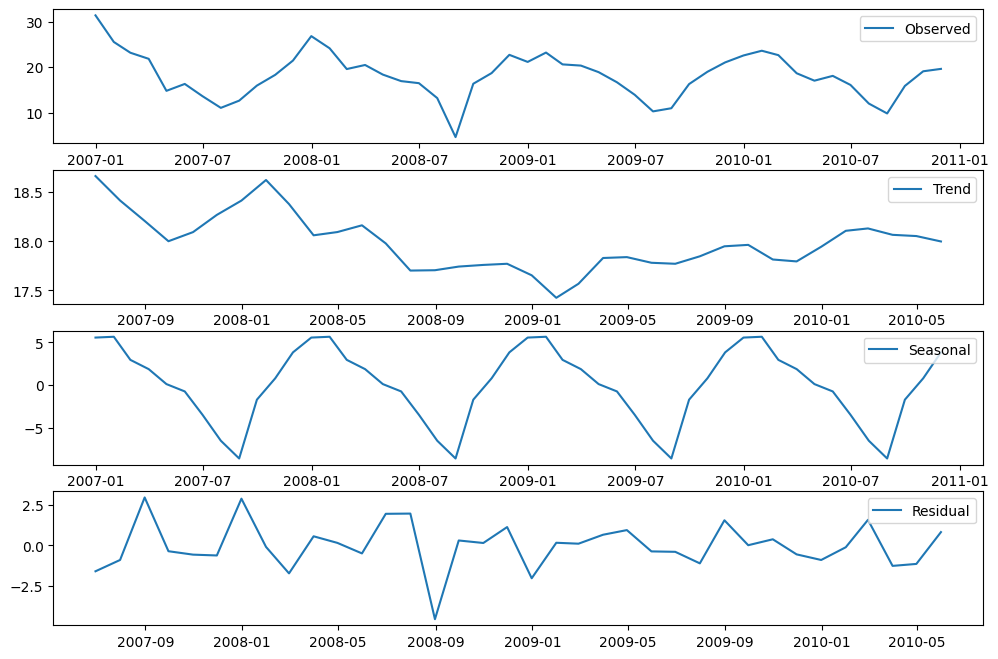

In [16]:
def check_seasonality_and_cyclical_patterns(df: pd.DataFrame):
    # Decompose the time series
    decomposition = seasonal_decompose(
        df["Global_active_power_wh"].dropna(), model="additive", #period=24
    )

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label="Observed")
    plt.legend(loc="upper right")
    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend")
    plt.legend(loc="upper right")
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal")
    plt.legend(loc="upper right")
    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual")
    plt.legend(loc="upper right")
    plt.show()


check_seasonality_and_cyclical_patterns(resampled_1min_to_24h_df)

**Conclusions** <br>
We can see that there is seasonality in the data.<br>
An increase in energy consumption in colder months (autumn and winter) and a reduction in the spring and summer months.<br>
The overall trend is not distinct, it probably fallows the weather of that year, a colder winter means higher energy consumption.<br>

## 2.3 Analyze Distribution of Power Consumption

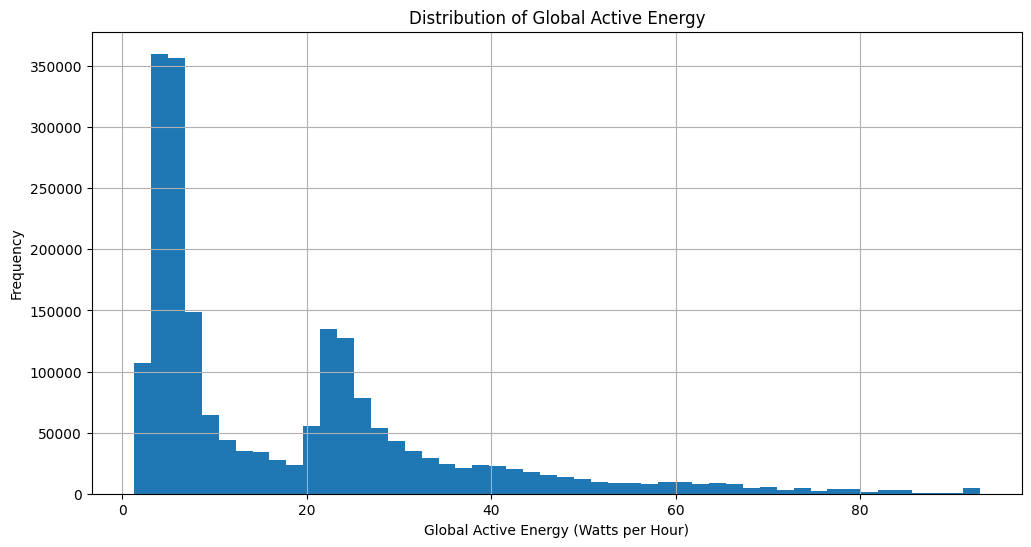

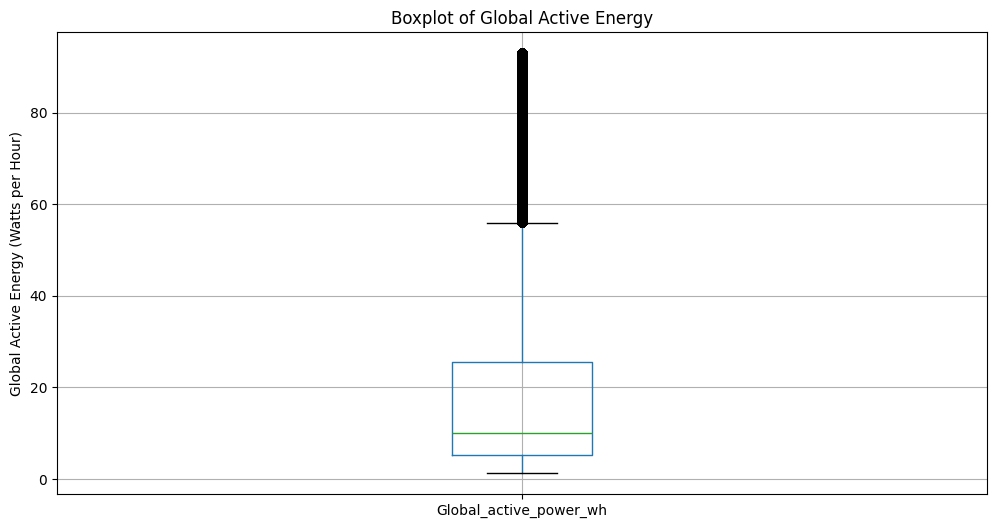

In [18]:
def analyze_distribution_of_power_consumption(df: pd.DataFrame):
    # Plot histogram
    plt.figure(figsize=(12, 6))
    df["Global_active_power_wh"].hist(bins=50)
    plt.xlabel("Global Active Energy (Watts per Hour)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Global Active Energy")
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    df.boxplot(column="Global_active_power_wh")
    plt.ylabel("Global Active Energy (Watts per Hour)")
    plt.title("Boxplot of Global Active Energy")
    plt.show()

analyze_distribution_of_power_consumption(full_df)

**Conclusions** <br>
From the energy distribution and from the boxplot, we can see that the majority of the energy consumption is low with a median less than 10. <br>
We see there are energy consumption peaks marked as outliers on the boxplot.

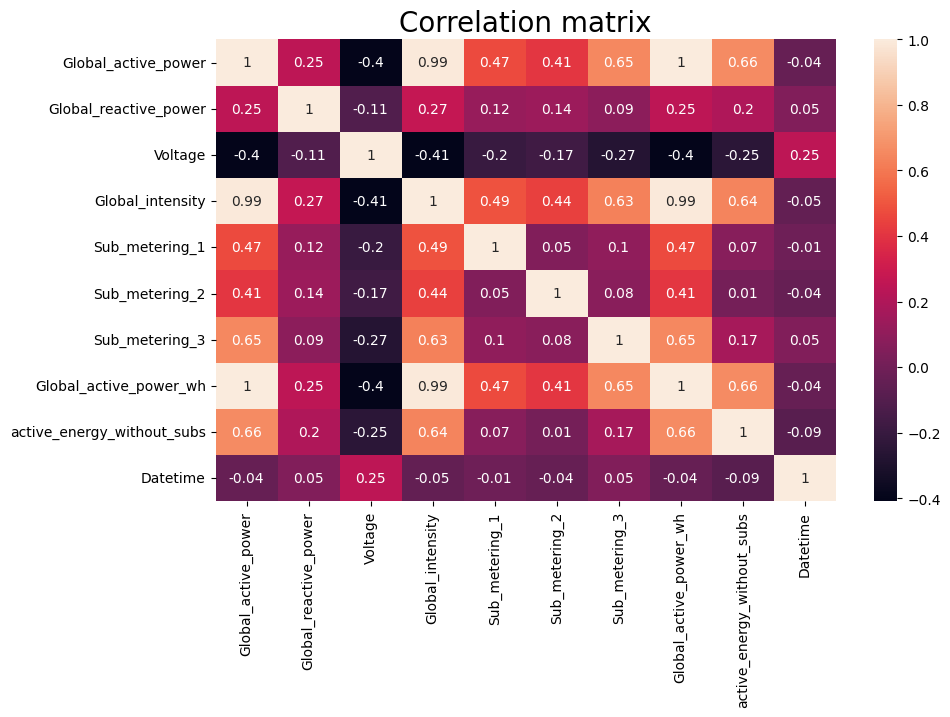

In [19]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(full_df.corr().round(2),annot=True)
plt.title('Correlation matrix',fontsize = 20)
plt.show()

**Conclusions** <br>
As we wrote before, Global active energy/power is fully correlated to the global intensity. <br> We can see that the Global active energy/power is not fully correlated with the active energy without subs. So we think it has information that may help the prediction.

# 3. Implement a linear regression model to predict power consumption for the last three time periods

In [ ]:
from src.task_2.models.linear_regression import run_linear_regression_e2e

In [ ]:
lr_results = run_linear_regression_e2e(full_df)

# 4. Evaluate the linear regression model using appropriate metrics

In [ ]:
print(json.dumps(lr_results, indent=1))

# create data for neural networks

In [28]:
# Define the target variable and features
features = ['Global_active_power_wh','active_energy_without_subs', 'Global_active_power_lag1']
target = 'Global_active_power'

def create_sequences(data, sequence_length, features, label):
    sequences = []
    targets = []
    for i in range(0, len(data) - sequence_length, sequence_length):
        seq = data[features].iloc[i:i + sequence_length].values
        label = data[target].iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 60
sequences, targets = create_sequences(df_hourly, sequence_length, features, target)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

scaler_y = MinMaxScaler()

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [ ]:

## LSTM model

import tensorflow as tf
from keras import Sequential
from keras import layers
from keras import callbacks

# Design the LSTM model
model = Sequential()
model.add(layers.LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])


## LSTM predictions
# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Inverse transform the predictions and actual values
y_test_inv = scaler_y.inverse_transform(y_test_scaled).reshape(-1) * (100 / 60)
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test).reshape(-1)

# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
mse = mean_squared_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)

print(f"LSTM - MAE: {mae}, MSE: {mse}, R²: {r2}")

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('Actual vs Predicted Global Active Power (LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# 5. Implement a Recurrent Neural Network (RNN) for power consumption prediction

In [ ]:
from src.task_2.preprocessing.sequence import split_data_x_and_y

In [ ]:
# resample to reduce training time
df_resample = full_df.resample('h').mean() 
df_resample.shape

# create global scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_resample)

# split into X and y
X, y = split_data_x_and_y(df_resample)


In [ ]:
# Normalize data using the global scaler
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y.reshape(-1, 1))


In [ ]:
def create_sequences_x_and_y(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        a = data[i : (i + seq_length), 0]
        X.append(a)
        y.append(target[i + seq_length, 0])
    return np.array(X), np.array(y)


In [ ]:
t,z = create_sequences_x_and_y(scaled_X, scaled_y, 60)

In [11]:
from src.task_2.models.rnn import build_rnn_model

model = build_rnn_model(60)

c:\Afeka\Afeka_DL_course_labs\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from keras import layers, Sequential

# Design the RNN model
rnn_model = Sequential()
rnn_model.add(layers.SimpleRNN(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
rnn_model.add(layers.BatchNormalization())
rnn_model.add(layers.Dropout(0.2))
rnn_model.add(layers.Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

# Train the RNN model
rnn_history = rnn_model.fit(X_train_scaled, y_train, epochs=25, batch_size=64, verbose=2, shuffle=False)


Epoch 1/25
8/8 - 4s - 516ms/step - loss: 3.7816
Epoch 2/25
8/8 - 0s - 15ms/step - loss: 2.4407
Epoch 3/25
8/8 - 0s - 15ms/step - loss: 2.2100
Epoch 4/25
8/8 - 0s - 16ms/step - loss: 1.9616
Epoch 5/25
8/8 - 0s - 14ms/step - loss: 1.6252
Epoch 6/25
8/8 - 0s - 14ms/step - loss: 1.4719
Epoch 7/25
8/8 - 0s - 14ms/step - loss: 1.6409
Epoch 8/25
8/8 - 0s - 13ms/step - loss: 1.4480
Epoch 9/25
8/8 - 0s - 12ms/step - loss: 1.1928
Epoch 10/25
8/8 - 0s - 11ms/step - loss: 1.0329
Epoch 11/25
8/8 - 0s - 12ms/step - loss: 0.9036
Epoch 12/25
8/8 - 0s - 11ms/step - loss: 0.8919
Epoch 13/25
8/8 - 0s - 11ms/step - loss: 0.9064
Epoch 14/25
8/8 - 0s - 10ms/step - loss: 0.7950
Epoch 15/25
8/8 - 0s - 11ms/step - loss: 0.8263
Epoch 16/25
8/8 - 0s - 12ms/step - loss: 0.7054
Epoch 17/25
8/8 - 0s - 11ms/step - loss: 0.6952
Epoch 18/25
8/8 - 0s - 32ms/step - loss: 0.6355
Epoch 19/25
8/8 - 0s - 31ms/step - loss: 0.6636
Epoch 20/25
8/8 - 0s - 21ms/step - loss: 0.5861
Epoch 21/25
8/8 - 0s - 21ms/step - loss: 0.6554


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
RNN - MAE: 3.43129118251012, MSE: 12.417418226752282, R²: -10.426249352535809


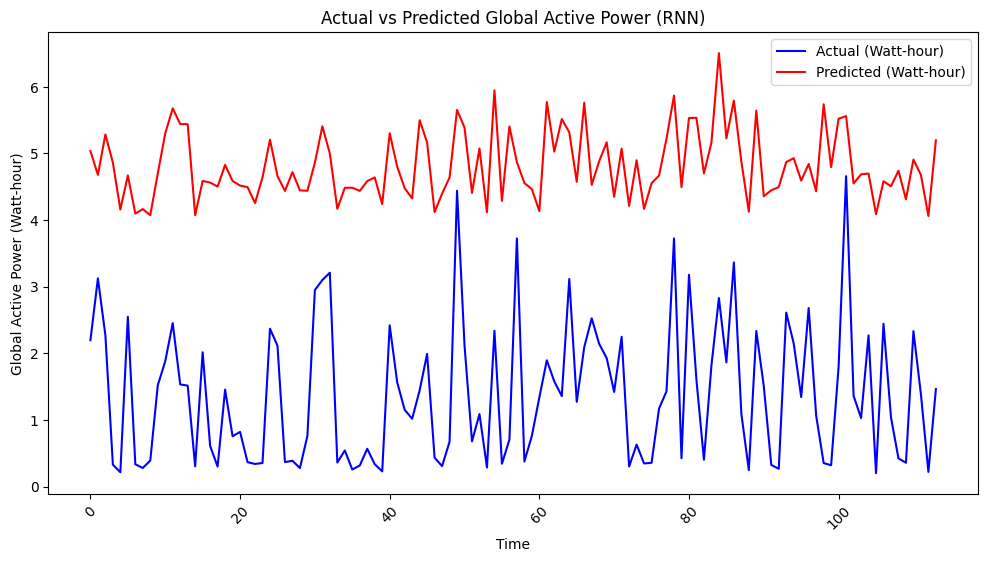

In [31]:
# Make predictions with the RNN model
y_pred_train_rnn = rnn_model.predict(X_train_scaled)
y_pred_test_rnn = rnn_model.predict(X_test_scaled)

# Inverse transform the predictions and actual values
y_pred_train_rnn_inv = scaler_y.inverse_transform(y_pred_train_rnn).reshape(-1)
y_pred_test_rnn_inv = scaler_y.inverse_transform(y_pred_test_rnn).reshape(-1)

# Inverse transform the predictions and actual values
y_test_inv = scaler_y.inverse_transform(y_test_scaled).reshape(-1)

# Evaluate RNN model performance
mae_rnn = mean_absolute_error(y_test_inv, y_pred_test_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, y_pred_test_rnn_inv)
r2_rnn = r2_score(y_test_inv, y_pred_test_rnn_inv)

print(f"RNN - MAE: {mae_rnn}, MSE: {mse_rnn}, R²: {r2_rnn}")

# Plot RNN predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_rnn_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('Actual vs Predicted Global Active Power (RNN)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
model.fit(X_augmented, y_augmented, epochs=10, batch_size=64)

In [ ]:
from src.task_2.models.rnn import run_rnn_model_e2e

In [ ]:
rnn_results = run_rnn_model_e2e(df_resample)
print(json.dumps(rnn_results, indent=1))

# 6. Implement Long Short-Term Memory (LSTM) for power consumption prediction

In [ ]:
from src.task_2.models.long_short_term_memory import run_lstm_model_e2e

In [ ]:
run_lstm_model_e2e(df_resample)

# 7. Implement an LSTM model with an Attention layer for power consumption prediction

In [ ]:
from src.task_2.models.lstm_with_attention import run_lstm_model_with_attention_e2e

In [ ]:
run_lstm_model_with_attention_e2e(df_resample)

# 8. Data augmentation experiment

In [ ]:
from src.task_2.preprocessing.sequence import augment_sequence_data

In [ ]:
from src.task_2.data_modification.augmentation import add_noise
# Reshape input to be [samples, time steps, features]
t = t.reshape(t.shape[0], t.shape[1], 1)

# Augment the data with noise
X_augmented = add_noise(t)
# Labels remain the same
y_augmented = z  

In [ ]:
X_augmented, y_augmented = augment_sequence(df_resample, sequence_length=60)

In [ ]:
from src.task_2.models.rnn import build_rnn_model
rnn_model = build_rnn_model(60)
history = rnn_model.fit(X_augmented, y_augmented, epochs=10, batch_size=64, verbose=1, callbacks=[early_stopping])

# 9. Data reduction experiment

In [ ]:
from src.task_2.data_modification.augmentation import reduce_data_randomly

In [ ]:
# Apply reduction
X_reduced, y_reduced = reduce_data_randomly(X, y, reduction_factor=0.1)

# 10. Data resolution experiment

In [ ]:
from data_modification.resolution import resample_data_from_1min_to_2min

In [ ]:
resampled_df = resample_data_from_1min_to_2min(full_df)

# 11. Conclusion and insights